In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load engineered features
df = pd.read_csv('../data/processed/transactions_features.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (100516, 47)

Columns: ['transaction_id', 'user_id', 'timestamp', 'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_early_morning', 'is_business_hours', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'amount_raw', 'amount_log', 'amount_very_small', 'amount_small', 'amount_medium', 'amount_large', 'amount_very_large', 'tx_count_1h', 'tx_count_24h', 'tx_amount_1h', 'tx_amount_24h', 'tx_amount_1h_log', 'tx_amount_24h_log', 'time_since_last_tx', 'avg_tx_amount_24h', 'user_tx_number', 'user_total_amount', 'user_avg_amount', 'user_std_amount', 'amount_deviation', 'amount_2x_avg', 'amount_3x_avg', 'is_new_receiver', 'receiver_tx_count', 'device_changed_flag', 'location_changed_flag', 'device_or_location_changed', 'device_and_location_changed', 'high_amount_at_night', 'new_receiver_large_amount', 'device_changed_unusual_amount', 'high_velocity_large_amount', 'night_device_change', 'is_fraud']

First few rows:


,transaction_id,user_id,timestamp,hour,day_of_week,is_weekend,is_night,is_early_morning,is_business_hours,hour_sin,...,device_changed_flag,location_changed_flag,device_or_location_changed,device_and_location_changed,high_amount_at_night,new_receiver_large_amount,device_changed_unusual_amount,high_velocity_large_amount,night_device_change,is_fraud
0,426912a2-6820-438b-ae8f-cccf5f961b43,sender_1005,2025-10-25 15:43:48.388718,15,5,1,0,0,1,-0.707107,...,0,0,0,0,0,0,0,0,0,True
1,bf1e9529-a625-438e-90d4-534bb148602d,sender_1033,2025-09-18 22:54:36.388718,22,3,0,1,0,0,-0.500000,...,0,0,0,0,0,1,0,0,0,True
2,01f92428-8ee0-4d12-ab7e-27281bd7b91b,sender_1048,2025-10-03 03:43:48.388718,3,4,0,1,1,0,0.707107,...,0,0,0,0,0,0,0,0,0,True
3,85c5f70a-00eb-490b-a7f9-a2023200c960,sender_1067,2025-10-24 20:27:52.388718,20,4,0,0,0,0,-0.866025,...,0,0,0,0,0,0,0,0,0,True
4,4344510e-fa0d-418e-b16d-662d436054fc,sender_1076,2025-10-16 21:06:53.388718,21,3,0,0,0,0,-0.707107,...,0,0,0,0,0,0,0,0,0,True


In [2]:
# Feature statistics
print("Feature Statistics:")
print("="*80)

feature_cols = [col for col in df.columns if col not in ['transaction_id', 'user_id', 'timestamp', 'is_fraud']]

print(f"Total features: {len(feature_cols)}")
print(f"\nSample features:")
for col in feature_cols[:10]:
    print(f"  - {col}")
print("  ...")


Feature Statistics:
Total features: 43

Sample features:
  - hour
  - day_of_week
  - is_weekend
  - is_night
  - is_early_morning
  - is_business_hours
  - hour_sin
  - hour_cos
  - day_sin
  - day_cos
  ...


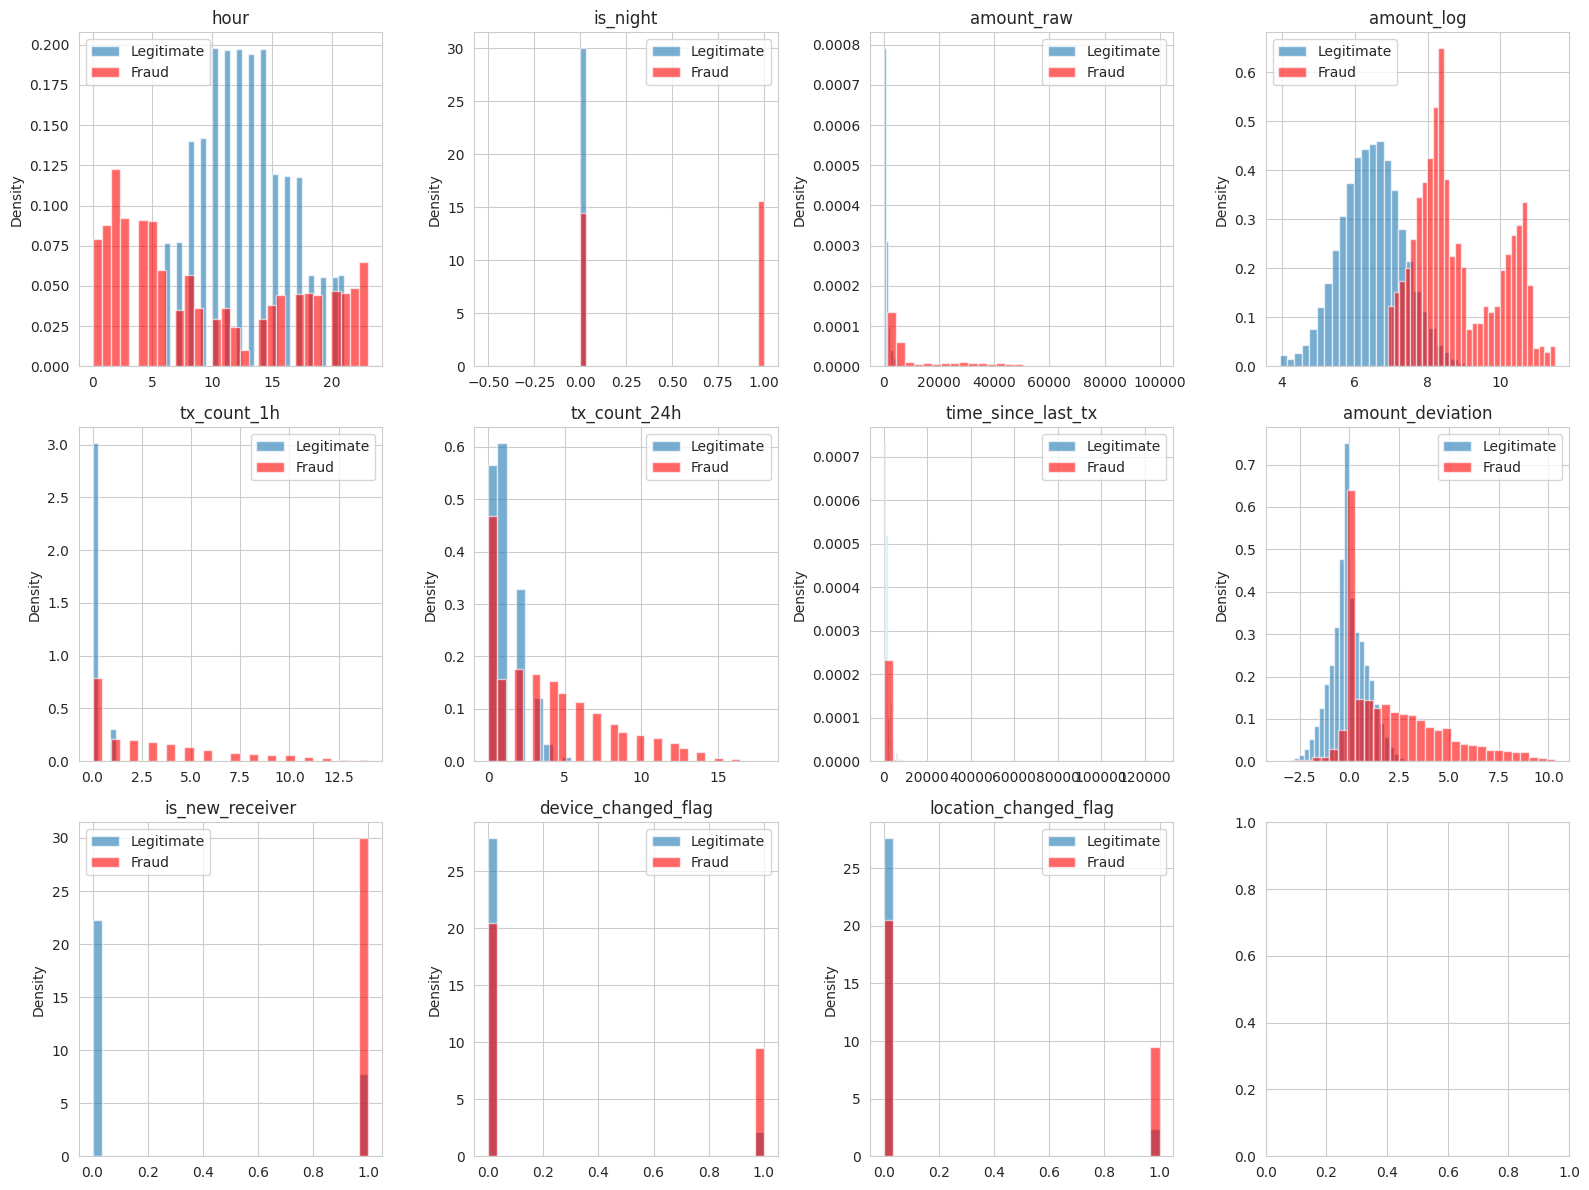

In [3]:
# Fraud vs Legitimate comparison for key features

key_features = [
    'hour', 'is_night', 'amount_raw', 'amount_log',
    'tx_count_1h', 'tx_count_24h', 'time_since_last_tx',
    'amount_deviation', 'is_new_receiver',
    'device_changed_flag', 'location_changed_flag'
]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Plot distributions
    df[~df['is_fraud']][feature].hist(bins=30, ax=ax, alpha=0.6, label='Legitimate', density=True)
    df[df['is_fraud']][feature].hist(bins=30, ax=ax, alpha=0.6, label='Fraud', density=True, color='red')
    
    ax.set_title(feature)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.savefig('../docs/feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

Top 20 Features Correlated with Fraud:
                               correlation
amount_2x_avg                     0.739051
is_night                          0.716064
amount_3x_avg                     0.667857
is_early_morning                  0.652553
new_receiver_large_amount         0.617351
high_amount_at_night              0.595873
tx_count_1h                       0.586511
amount_raw                        0.570803
tx_amount_1h                      0.547446
night_device_change               0.540033
device_changed_unusual_amount     0.538530
high_velocity_large_amount        0.530853
amount_very_large                 0.499509
device_and_location_changed       0.404815
tx_amount_1h_log                  0.399673
tx_amount_24h                     0.394117
amount_log                        0.394048
amount_deviation                  0.339300
avg_tx_amount_24h                 0.330416
tx_count_24h                      0.319239


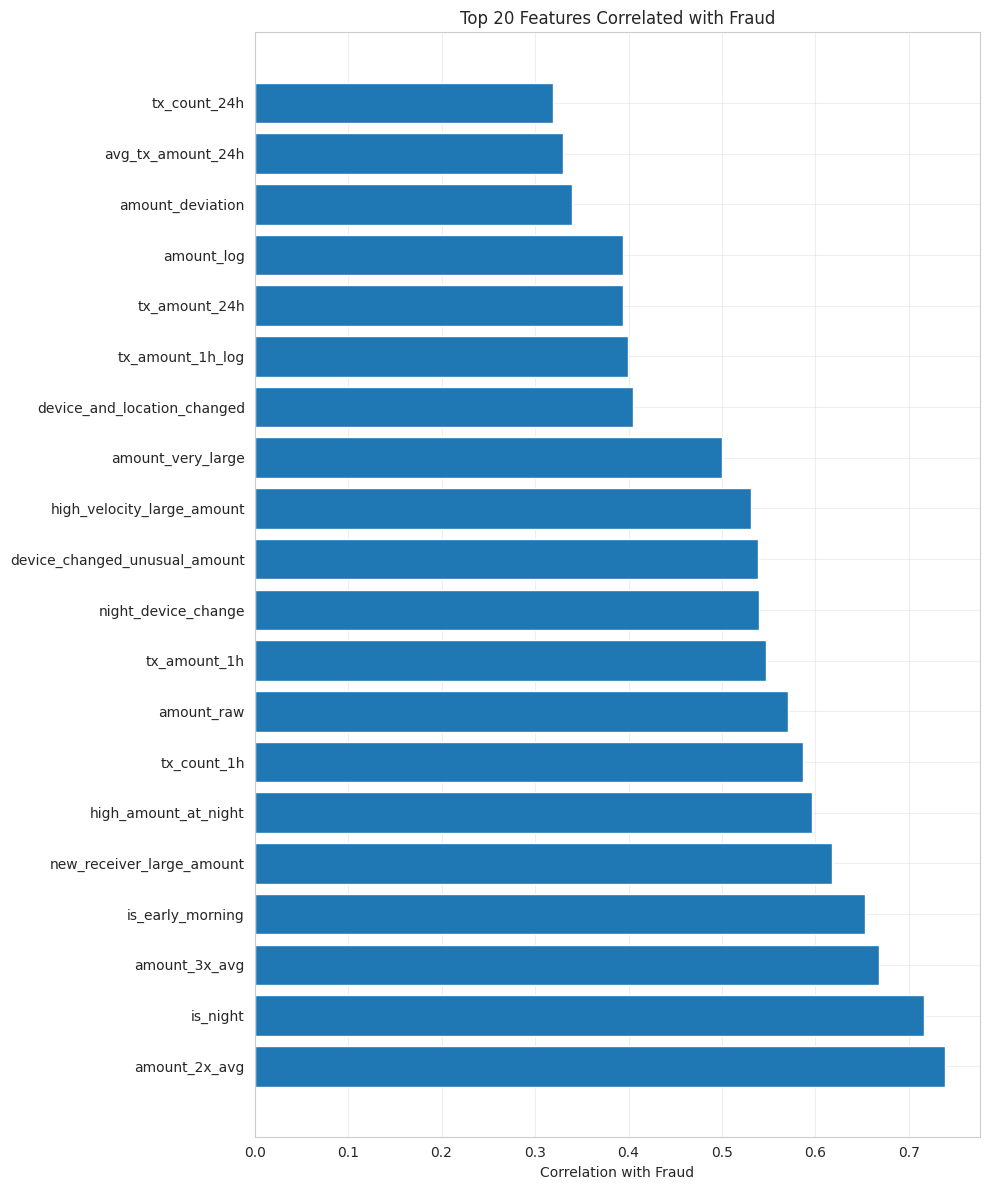

In [4]:
# Feature correlations with fraud

# Calculate correlation with target
correlations = {}
for col in feature_cols:
    if df[col].dtype in ['int64', 'float64']:
        corr = df[col].corr(df['is_fraud'])
        correlations[col] = corr

# Sort by absolute correlation
correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)

print("Top 20 Features Correlated with Fraud:")
print("="*80)
print(correlations_df.head(20))

# Visualize
plt.figure(figsize=(10, 12))
top_20 = correlations_df.head(20)
plt.barh(range(len(top_20)), top_20['correlation'].values)
plt.yticks(range(len(top_20)), top_20.index)
plt.xlabel('Correlation with Fraud')
plt.title('Top 20 Features Correlated with Fraud')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/feature_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

Training Random Forest for feature importance...
(This gives us initial sense of which features are predictive)

Top 20 Most Important Features:
                      feature  importance
19               tx_amount_1h    0.113707
21           tx_amount_1h_log    0.109408
30              amount_2x_avg    0.100754
3                    is_night    0.077491
23         time_since_last_tx    0.061361
4            is_early_morning    0.051492
31              amount_3x_avg    0.049384
17                tx_count_1h    0.047593
10                 amount_raw    0.046024
0                        hour    0.044123
11                 amount_log    0.029406
39  new_receiver_large_amount    0.027957
38       high_amount_at_night    0.025479
29           amount_deviation    0.025306
22          tx_amount_24h_log    0.022381
25             user_tx_number    0.018633
28            user_std_amount    0.016246
27            user_avg_amount    0.015700
7                    hour_cos    0.014519
26          use

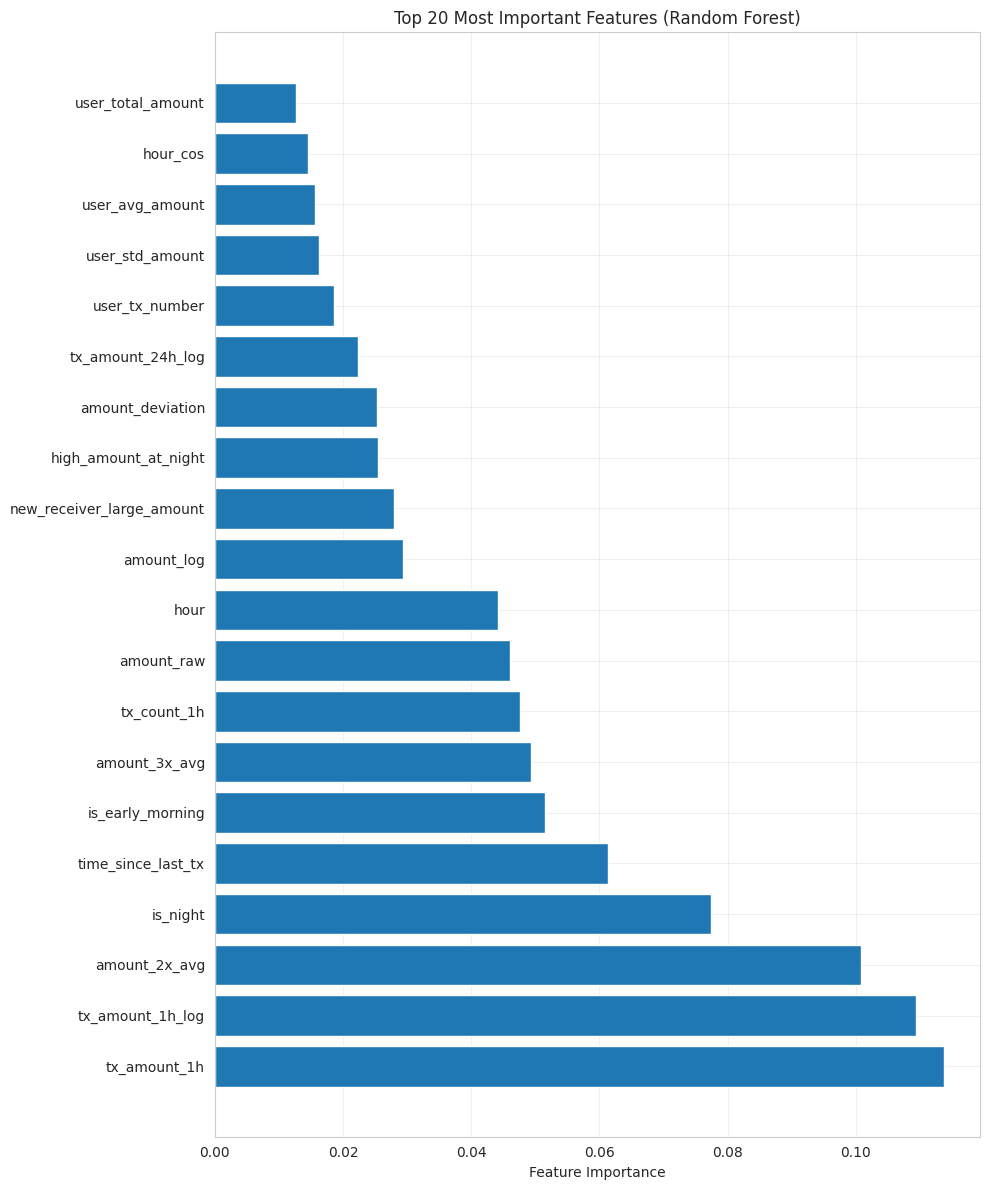

In [5]:
# Quick Random Forest for feature importance

print("Training Random Forest for feature importance...")
print("(This gives us initial sense of which features are predictive)")

# Prepare data
X = df[feature_cols].fillna(0)
y = df['is_fraud']

# Train simple RF (not optimized, just for feature importance)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

# Get feature importances
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("="*80)
print(importances.head(20))

# Visualize
plt.figure(figsize=(10, 12))
top_20_imp = importances.head(20)
plt.barh(range(len(top_20_imp)), top_20_imp['importance'].values)
plt.yticks(range(len(top_20_imp)), top_20_imp['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/feature_importance_rf.png', dpi=100, bbox_inches='tight')
plt.show()

In [6]:
# Feature value comparison (fraud vs legitimate)

comparison_features = [
    'hour', 'amount_raw', 'tx_count_1h', 'tx_count_24h',
    'amount_deviation', 'time_since_last_tx', 'is_night',
    'is_new_receiver', 'device_changed_flag'
]

comparison_df = pd.DataFrame()

for feature in comparison_features:
    legitimate_mean = df[~df['is_fraud']][feature].mean()
    fraud_mean = df[df['is_fraud']][feature].mean()
    
    legitimate_median = df[~df['is_fraud']][feature].median()
    fraud_median = df[df['is_fraud']][feature].median()
    
    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({
            'feature': [feature],
            'legitimate_mean': [legitimate_mean],
            'fraud_mean': [fraud_mean],
            'legitimate_median': [legitimate_median],
            'fraud_median': [fraud_median],
            'mean_diff': [fraud_mean - legitimate_mean],
            'median_diff': [fraud_median - legitimate_median]
        })
    ])

comparison_df = comparison_df.reset_index(drop=True)

print("\nFeature Value Comparison (Fraud vs Legitimate):")
print("="*80)
print(comparison_df.to_string(index=False))


Feature Value Comparison (Fraud vs Legitimate):
            feature  legitimate_mean   fraud_mean  legitimate_median  fraud_median    mean_diff  median_diff
               hour        12.635143     9.588235          12.000000      7.000000    -3.046908    -5.000000
         amount_raw       930.856714 13546.727092         642.270000   4690.831175 12615.870378  4048.561175
        tx_count_1h         0.101673     3.011129           0.000000      2.000000     2.909455     2.000000
       tx_count_24h         1.105673     3.852941           1.000000      3.000000     2.747268     2.000000
   amount_deviation        -0.039818     2.168937          -0.128406      1.477986     2.208755     1.606392
 time_since_last_tx      1292.093092   496.281797        1144.000000      2.000000  -795.811295 -1142.000000
           is_night         0.000000     0.519078           0.000000      1.000000     0.519078     1.000000
    is_new_receiver         0.257582     0.999205           0.000000      1.000

In [7]:
# Interaction feature analysis

interaction_features = [
    'high_amount_at_night',
    'new_receiver_large_amount',
    'device_changed_unusual_amount',
    'high_velocity_large_amount',
    'night_device_change'
]

print("\nInteraction Feature Analysis:")
print("="*80)

for feature in interaction_features:
    fraud_rate = df[df[feature] == 1]['is_fraud'].mean()
    overall_fraud_rate = df['is_fraud'].mean()
    lift = fraud_rate / overall_fraud_rate if overall_fraud_rate > 0 else 0
    
    print(f"\n{feature}:")
    print(f"  Fraud rate when TRUE: {fraud_rate:.2%}")
    print(f"  Overall fraud rate: {overall_fraud_rate:.2%}")
    print(f"  Lift: {lift:.2f}x")
    print(f"  Count: {(df[feature] == 1).sum():,}")


Interaction Feature Analysis:

high_amount_at_night:
  Fraud rate when TRUE: 100.00%
  Overall fraud rate: 2.50%
  Lift: 39.95x
  Count: 908

new_receiver_large_amount:
  Fraud rate when TRUE: 84.21%
  Overall fraud rate: 2.50%
  Lift: 33.64x
  Count: 1,381

device_changed_unusual_amount:
  Fraud rate when TRUE: 99.47%
  Overall fraud rate: 2.50%
  Lift: 39.74x
  Count: 751

high_velocity_large_amount:
  Fraud rate when TRUE: 100.00%
  Overall fraud rate: 2.50%
  Lift: 39.95x
  Count: 722

night_device_change:
  Fraud rate when TRUE: 100.00%
  Overall fraud rate: 2.50%
  Lift: 39.95x
  Count: 747


In [8]:
# Save feature summary

feature_summary = pd.DataFrame({
    'feature': feature_cols,
    'dtype': [df[col].dtype for col in feature_cols],
    'missing': [df[col].isnull().sum() for col in feature_cols],
    'unique': [df[col].nunique() for col in feature_cols],
    'mean': [df[col].mean() if df[col].dtype in ['int64', 'float64'] else None for col in feature_cols],
    'std': [df[col].std() if df[col].dtype in ['int64', 'float64'] else None for col in feature_cols],
})

feature_summary.to_csv('../data/processed/feature_summary.csv', index=False)
print("\n✅ Feature summary saved to: data/processed/feature_summary.csv")


✅ Feature summary saved to: data/processed/feature_summary.csv
